# Análisis Base de datos abierta EDS
En este notebook se mira la estructura de los datos de :

Estaciones de Servicio Automotriz y Fluvial:Despacho de combustibles líquidos a nivel nacional (AUTOMATIZADO)

disponible en :
https://www.datos.gov.co/Minas-y-Energ-a/Estaciones-de-Servicio-Automotriz-y-Fluvial-Despac/fbht-2fzd/about_data


In [3]:
from sodapy import Socrata
import pandas as pd

# Conexión a la API de Socrata
client = Socrata("www.datos.gov.co", None)

# ID del dataset: fbht-2fzd 
dataset = "fbht-2fzd"

# Get all data
results = client.get(dataset)

# Convertir a DataFrame de pandas
df = pd.DataFrame.from_records(results)

# Get column info
column_info = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': df.dtypes
})

print("Column Information:")
print(column_info)

# Save column info to CSV file
column_info.to_csv('column_info.csv', index=False)


Column Information:
                                                 Column Name Data Type
fecha_despacho                                fecha_despacho    object
anio_despacho                                  anio_despacho    object
mes_despacho                                    mes_despacho    object
dia_despacho                                    dia_despacho    object
tipo_proveedor                                tipo_proveedor    object
codigo_municipio_dane                  codigo_municipio_dane    object
departamento_proveedor                departamento_proveedor    object
municipio_proveedor                      municipio_proveedor    object
tipo_comprador                                tipo_comprador    object
zona_frontera                                  zona_frontera    object
subtipo_comprador                          subtipo_comprador    object
codigo_municipio_dane_destino  codigo_municipio_dane_destino    object
departamento                                    departame

In [7]:
unique_tipo_proveedor = client.get(dataset, select="DISTINCT tipo_proveedor")
df_unique_tipo_proveedor = pd.DataFrame.from_records(unique_tipo_proveedor)
print("\nDifferent values in tipo_comprador:")
print(df_unique_tipo_proveedor)



Different values in tipo_comprador:
           tipo_proveedor
0  DISTRIBUIDOR MAYORISTA


In [11]:
unique_tipo_comprador = client.get(dataset, select="DISTINCT tipo_comprador")
df_unique_tipo_comprador = pd.DataFrame.from_records(unique_tipo_comprador)
print("\nDifferent values in tipo_comprador:")
print(df_unique_tipo_comprador)



Different values in tipo_comprador:
           tipo_comprador
0  DISTRIBUIDOR MINORISTA


In [8]:
unique_subtipo_comprador = client.get(dataset, select="DISTINCT subtipo_comprador")
df_unique_subtipo_comprador = pd.DataFrame.from_records(unique_subtipo_comprador)
print("\nDifferent values in tipo_comprador:")
print(df_unique_subtipo_comprador)


Different values in tipo_comprador:
                 subtipo_comprador
0  ESTACION DE SERVICIO AUTOMOTRIZ
1     ESTACION DE SERVICIO FLUVIAL


In [9]:
unique_producto = client.get(dataset, select="DISTINCT producto")
df_unique_producto = pd.DataFrame.from_records(unique_producto)
print("\nDifferent values in tipo_comprador:")
print(df_unique_producto)


Different values in tipo_comprador:
                   producto
0      GASOLINA MOTOR EXTRA
1      BIODIESEL CON MEZCLA
2             DIESEL MARINO
3  GASOLINA MOTOR CORRIENTE


In [13]:
import json

unique_values = {
    'tipo_proveedor': df_unique_tipo_proveedor['tipo_proveedor'].tolist(),
    'tipo_comprador': df_unique_tipo_comprador['tipo_comprador'].tolist(),
    'subtipo_comprador': df_unique_subtipo_comprador['subtipo_comprador'].tolist(),
    'producto': df_unique_producto['producto'].tolist()
}

with open('unique_values.json', 'w', encoding='utf-8') as f:
    json.dump(unique_values, f, ensure_ascii=False, indent=4)

In [14]:
from tabulate import tabulate
import pandas as pd

# Convert the dictionary to a DataFrame with equal length columns
max_len = max(len(v) for v in unique_values.values())
df_display = pd.DataFrame({
    k: v + [''] * (max_len - len(v))
    for k, v in unique_values.items()
})

print(tabulate(df_display, headers='keys', tablefmt='grid', showindex=False))


+------------------------+------------------------+---------------------------------+--------------------------+
| tipo_proveedor         | tipo_comprador         | subtipo_comprador               | producto                 |
+========================+========================+=================================+==========================+
| DISTRIBUIDOR MAYORISTA | DISTRIBUIDOR MINORISTA | ESTACION DE SERVICIO AUTOMOTRIZ | GASOLINA MOTOR EXTRA     |
+------------------------+------------------------+---------------------------------+--------------------------+
|                        |                        | ESTACION DE SERVICIO FLUVIAL    | BIODIESEL CON MEZCLA     |
+------------------------+------------------------+---------------------------------+--------------------------+
|                        |                        |                                 | DIESEL MARINO            |
+------------------------+------------------------+---------------------------------+-----------

In [20]:
query = """
        SELECT anio_despacho,
               mes_despacho,
               producto,
               SUM(volumen_despachado) as volumen_total
        WHERE anio_despacho in ('2023', '2024')
          AND subtipo_comprador = 'ESTACION DE SERVICIO AUTOMOTRIZ'
          AND producto != 'DIESEL MARINO'
        GROUP BY anio_despacho, mes_despacho, producto
        ORDER BY anio_despacho, mes_despacho, producto \
        """
consumo = client.get(dataset, query=query)
df_consumo = pd.DataFrame.from_records(consumo)
df_consumo.to_csv('consumo_23_24.csv', index=False)


In [22]:

# 1. Ensure your volume is actually numeric
df_consumo['volumen_total'] = pd.to_numeric(df_consumo['volumen_total'], errors='coerce')

# 2. Make sure month is integer (in case it’s still a string)
df_consumo['mes_despacho'] = df_consumo['mes_despacho'].astype(int)

# 3. Map month to quarter
df_consumo['quarter'] = ((df_consumo['mes_despacho'] - 1) // 3 + 1).map(lambda q: f"Q{q}")

# 4. Group by year, quarter, product and sum
consumo_q_23_24 = (
    df_consumo
    .groupby(['anio_despacho', 'quarter', 'producto'], as_index=False)
    .agg(volumen_total=('volumen_total', 'sum'))
)

# 5. (Optional) save to CSV
consumo_q_23_24.to_csv('consumo_q_23_24.csv', index=False)

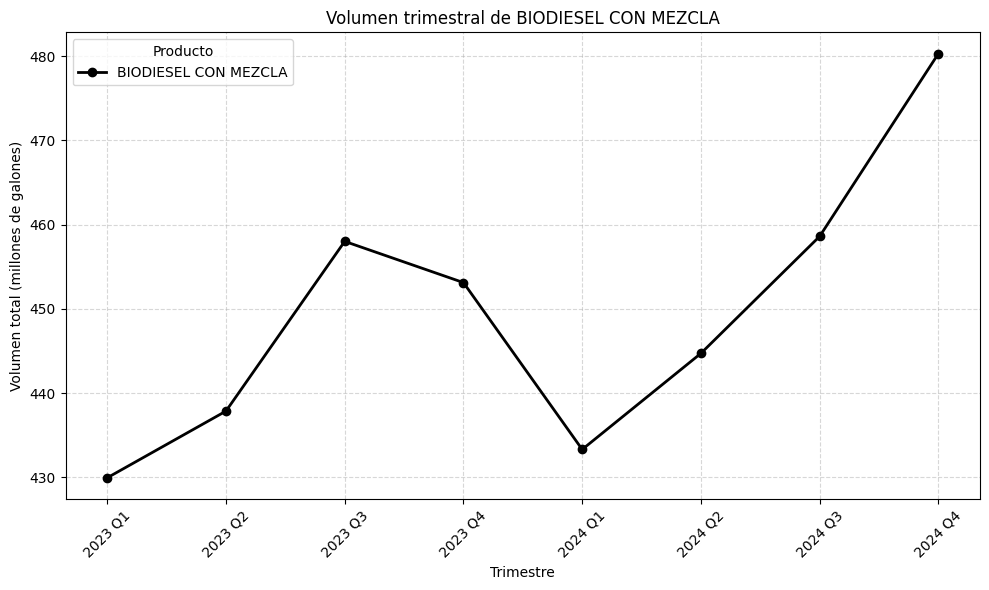

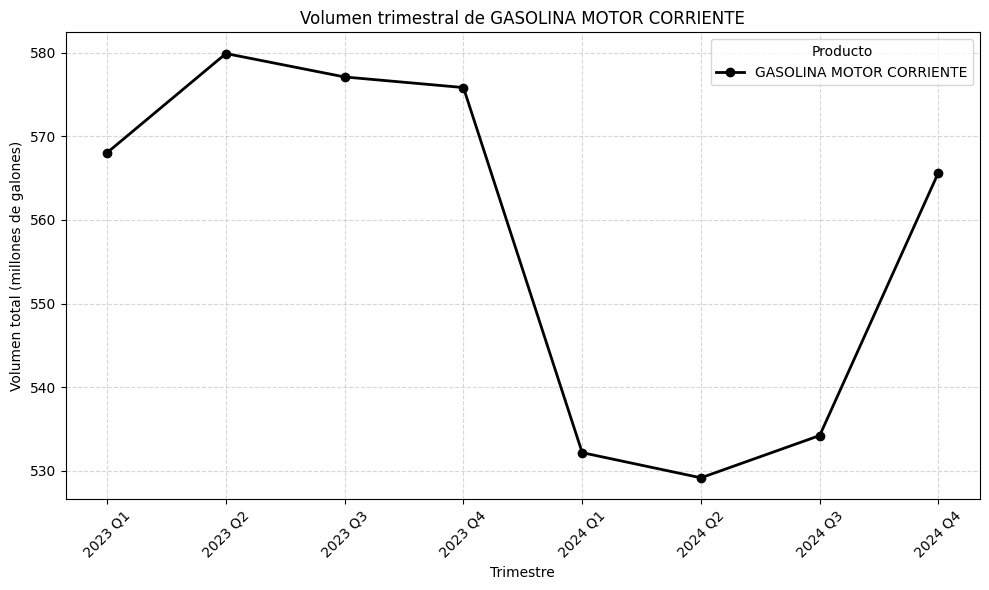

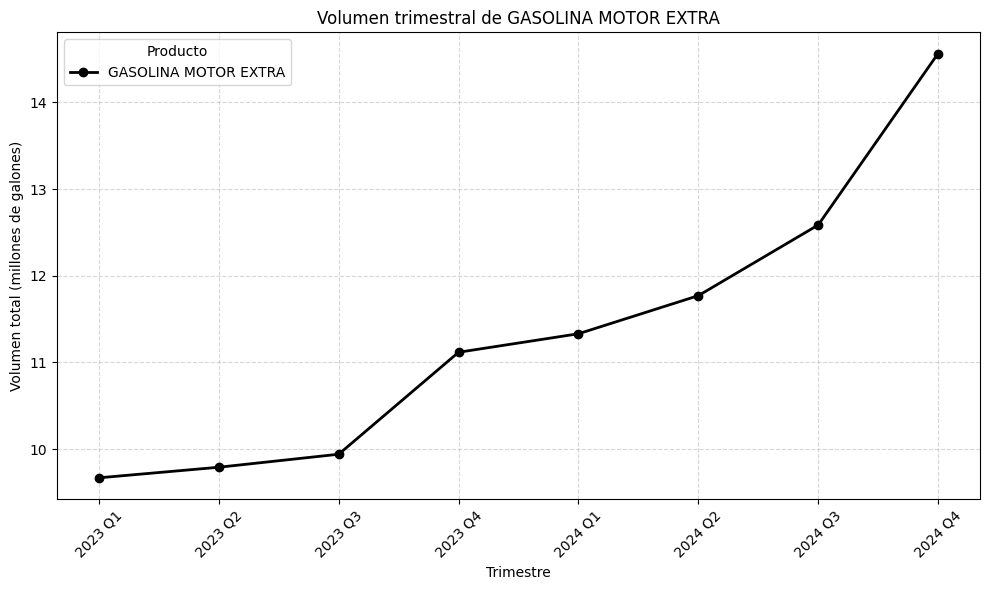

In [26]:
import matplotlib.pyplot as plt

# 1. Asegúrate de que está ordenado cronológicamente
consumo_q_23_24 = consumo_q_23_24.sort_values(['anio_despacho', 'quarter'])

# 2. Mapeos de nombre en leyenda (español) y color por producto
nombre_leyenda = {
    'Gasolina Corriente': 'Gasolina Corriente',
    'Gasolina Extra': 'Gasolina Extra',
    'Biodiésel':      'Biodiésel'
}
colores = {
    'Gasolina Corriente': 'green',
    'Gasolina Extra':     'gray',
    'Biodiésel':          'blue'
}

# 3. Bucle para dibujar cada producto
for prod in consumo_q_23_24['producto'].unique():
    data = consumo_q_23_24[consumo_q_23_24['producto'] == prod]

    # Etiquetas del eje X: "2023 Q1", "2023 Q2", …
    trimestres = [f"{y} {q}" for y, q in zip(data['anio_despacho'], data['quarter'])]

    # Volumen en millones de galones
    volumen_millones = data['volumen_total'] / 1e6

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        trimestres,
        volumen_millones,
        marker='o',
        linewidth=2,
        color=colores.get(prod, 'black'),
        label=nombre_leyenda.get(prod, prod)
    )

    ax.set_title(f'Volumen trimestral de {nombre_leyenda.get(prod, prod)}')
    ax.set_xlabel('Trimestre')
    ax.set_ylabel('Volumen total (millones de galones)')
    ax.legend(title='Producto')
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [27]:
# 1. Asegúrate de que está ordenado cronológicamente
consumo_q_23_24 = consumo_q_23_24.sort_values(['anio_despacho', 'quarter'])

# 2. Mapeos de nombre en leyenda (español) y color por producto
nombre_leyenda = {
    'Gasolina Corriente': 'Gasolina Corriente',
    'Gasolina Extra': 'Gasolina Extra',
    'Biodiésel': 'Biodiésel'
}
colores = {
    'Gasolina Corriente': 'green',
    'Gasolina Extra': 'gray',
    'Biodiésel': 'blue'
}

# 3. Bucle para dibujar cada producto
for prod in consumo_q_23_24['producto'].unique():
    data = consumo_q_23_24[consumo_q_23_24['producto'] == prod]

    trimestres = [f"{y} {q}" for y, q in zip(data['anio_despacho'], data['quarter'])]
    volumen_millones = data['volumen_total'] / 1e6

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        trimestres,
        volumen_millones,
        marker='o',
        linewidth=2,
        color=colores.get(prod, 'black'),
        label=nombre_leyenda.get(prod, prod)
    )

    ax.set_title(f'Volumen trimestral de {nombre_leyenda.get(prod, prod)}')
    ax.set_xlabel('Trimestre')
    ax.set_ylabel('Volumen total (millones de galones)')
    ax.legend(title='Producto')
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save figure
    filename = f'volumen_trimestral_{prod.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
